In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2538562/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 77xb9byl


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-77xb9byl:best, 58.49MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                              | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                                      | 1/2604 [00:00<22:32,  1.92it/s]

  0%|▎                                                                                                                     | 6/2604 [00:00<03:37, 11.93it/s]

  0%|▍                                                                                                                    | 11/2604 [00:00<02:08, 20.11it/s]

  1%|▋                                                                                                                    | 16/2604 [00:00<01:37, 26.51it/s]

  1%|▉                                                                                                                    | 21/2604 [00:00<01:22, 31.37it/s]

  1%|█▏                                                                                                                   | 26/2604 [00:01<01:12, 35.42it/s]

  1%|█▍                                                                                                                   | 31/2604 [00:01<01:06, 38.65it/s]

  1%|█▌                                                                                                                   | 36/2604 [00:01<01:02, 41.04it/s]

  2%|█▊                                                                                                                   | 41/2604 [00:01<00:59, 42.83it/s]

  2%|██                                                                                                                   | 46/2604 [00:01<00:58, 44.08it/s]

  2%|██▎                                                                                                                  | 51/2604 [00:01<00:56, 44.97it/s]

  2%|██▌                                                                                                                  | 56/2604 [00:01<00:55, 45.59it/s]

  2%|██▋                                                                                                                  | 61/2604 [00:01<00:55, 46.08it/s]

  3%|██▉                                                                                                                  | 66/2604 [00:01<00:54, 46.38it/s]

  3%|███▏                                                                                                                 | 71/2604 [00:02<00:54, 46.60it/s]

  3%|███▍                                                                                                                 | 76/2604 [00:02<00:54, 46.79it/s]

  3%|███▋                                                                                                                 | 81/2604 [00:02<00:53, 46.87it/s]

  3%|███▊                                                                                                                 | 86/2604 [00:02<00:53, 46.93it/s]

  3%|████                                                                                                                 | 91/2604 [00:02<00:53, 47.00it/s]

  4%|████▎                                                                                                                | 96/2604 [00:02<00:53, 47.08it/s]

  4%|████▍                                                                                                               | 101/2604 [00:02<00:53, 47.09it/s]

  4%|████▋                                                                                                               | 106/2604 [00:02<00:53, 47.09it/s]

  4%|████▉                                                                                                               | 111/2604 [00:02<00:52, 47.15it/s]

  4%|█████▏                                                                                                              | 116/2604 [00:02<00:52, 47.15it/s]

  5%|█████▍                                                                                                              | 121/2604 [00:03<00:52, 47.15it/s]

  5%|█████▌                                                                                                              | 126/2604 [00:03<00:52, 47.14it/s]

  5%|█████▊                                                                                                              | 131/2604 [00:03<00:52, 47.19it/s]

  5%|██████                                                                                                              | 136/2604 [00:03<00:52, 47.18it/s]

  5%|██████▎                                                                                                             | 141/2604 [00:03<00:52, 47.16it/s]

  6%|██████▌                                                                                                             | 146/2604 [00:03<00:52, 47.19it/s]

  6%|██████▋                                                                                                             | 151/2604 [00:03<00:51, 47.19it/s]

  6%|██████▉                                                                                                             | 156/2604 [00:03<00:51, 47.18it/s]

  6%|███████▏                                                                                                            | 161/2604 [00:03<00:51, 47.16it/s]

  6%|███████▍                                                                                                            | 166/2604 [00:04<00:51, 47.21it/s]

  7%|███████▌                                                                                                            | 171/2604 [00:04<00:51, 47.19it/s]

  7%|███████▊                                                                                                            | 176/2604 [00:04<00:51, 47.18it/s]

  7%|████████                                                                                                            | 181/2604 [00:04<00:51, 47.20it/s]

  7%|████████▎                                                                                                           | 186/2604 [00:04<00:51, 47.18it/s]

  7%|████████▌                                                                                                           | 191/2604 [00:04<00:51, 47.16it/s]

  8%|████████▋                                                                                                           | 196/2604 [00:04<00:51, 47.14it/s]

  8%|████████▉                                                                                                           | 201/2604 [00:04<00:51, 47.08it/s]

  8%|█████████▏                                                                                                          | 206/2604 [00:04<00:50, 47.10it/s]

  8%|█████████▍                                                                                                          | 211/2604 [00:05<00:50, 47.11it/s]

  8%|█████████▌                                                                                                          | 216/2604 [00:05<00:50, 47.12it/s]

  8%|█████████▊                                                                                                          | 221/2604 [00:05<00:50, 47.16it/s]

  9%|██████████                                                                                                          | 226/2604 [00:05<00:50, 47.07it/s]

  9%|██████████▎                                                                                                         | 231/2604 [00:05<00:50, 47.03it/s]

  9%|██████████▌                                                                                                         | 236/2604 [00:05<00:50, 47.12it/s]

  9%|██████████▋                                                                                                         | 241/2604 [00:05<00:50, 47.13it/s]

  9%|██████████▉                                                                                                         | 246/2604 [00:05<00:50, 47.13it/s]

 10%|███████████▏                                                                                                        | 251/2604 [00:05<00:49, 47.11it/s]

 10%|███████████▍                                                                                                        | 256/2604 [00:05<00:49, 47.12it/s]

 10%|███████████▋                                                                                                        | 261/2604 [00:06<00:49, 47.12it/s]

 10%|███████████▊                                                                                                        | 266/2604 [00:06<00:49, 47.17it/s]

 10%|████████████                                                                                                        | 271/2604 [00:06<00:49, 47.15it/s]

 11%|████████████▎                                                                                                       | 276/2604 [00:06<00:49, 47.16it/s]

 11%|████████████▌                                                                                                       | 281/2604 [00:06<00:49, 47.17it/s]

 11%|████████████▋                                                                                                       | 286/2604 [00:06<00:49, 47.10it/s]

 11%|████████████▉                                                                                                       | 291/2604 [00:06<00:49, 47.05it/s]

 11%|█████████████▏                                                                                                      | 296/2604 [00:06<00:49, 47.07it/s]

 12%|█████████████▍                                                                                                      | 301/2604 [00:06<00:48, 47.13it/s]

 12%|█████████████▋                                                                                                      | 306/2604 [00:07<00:48, 47.12it/s]

 12%|█████████████▊                                                                                                      | 311/2604 [00:07<00:48, 47.13it/s]

 12%|██████████████                                                                                                      | 316/2604 [00:07<00:48, 47.17it/s]

 12%|██████████████▎                                                                                                     | 321/2604 [00:07<00:48, 47.14it/s]

 13%|██████████████▌                                                                                                     | 326/2604 [00:07<00:48, 47.12it/s]

 13%|██████████████▋                                                                                                     | 331/2604 [00:07<00:48, 47.12it/s]

 13%|██████████████▉                                                                                                     | 336/2604 [00:07<00:48, 47.17it/s]

 13%|███████████████▏                                                                                                    | 341/2604 [00:07<00:48, 47.14it/s]

 13%|███████████████▍                                                                                                    | 346/2604 [00:07<00:47, 47.13it/s]

 13%|███████████████▋                                                                                                    | 351/2604 [00:07<00:47, 47.14it/s]

 14%|███████████████▊                                                                                                    | 356/2604 [00:08<00:47, 47.19it/s]

 14%|████████████████                                                                                                    | 361/2604 [00:08<00:47, 47.15it/s]

 14%|████████████████▎                                                                                                   | 366/2604 [00:08<00:47, 47.09it/s]

 14%|████████████████▌                                                                                                   | 371/2604 [00:08<00:47, 47.12it/s]

 14%|████████████████▋                                                                                                   | 376/2604 [00:08<00:47, 47.16it/s]

 15%|████████████████▉                                                                                                   | 381/2604 [00:08<00:47, 47.16it/s]

 15%|█████████████████▏                                                                                                  | 386/2604 [00:08<00:47, 47.15it/s]

 15%|█████████████████▍                                                                                                  | 391/2604 [00:08<00:46, 47.20it/s]

 15%|█████████████████▋                                                                                                  | 396/2604 [00:08<00:46, 47.19it/s]

 15%|█████████████████▊                                                                                                  | 401/2604 [00:09<00:46, 47.17it/s]

 16%|██████████████████                                                                                                  | 406/2604 [00:09<00:46, 47.09it/s]

 16%|██████████████████▎                                                                                                 | 411/2604 [00:09<00:46, 47.09it/s]

 16%|██████████████████▌                                                                                                 | 416/2604 [00:09<00:46, 47.10it/s]

 16%|██████████████████▊                                                                                                 | 421/2604 [00:09<00:46, 47.11it/s]

 16%|██████████████████▉                                                                                                 | 426/2604 [00:09<00:46, 47.12it/s]

 17%|███████████████████▏                                                                                                | 431/2604 [00:09<00:46, 47.16it/s]

 17%|███████████████████▍                                                                                                | 436/2604 [00:09<00:45, 47.16it/s]

 17%|███████████████████▋                                                                                                | 441/2604 [00:09<00:45, 47.14it/s]

 17%|███████████████████▊                                                                                                | 446/2604 [00:09<00:45, 47.18it/s]

 17%|████████████████████                                                                                                | 451/2604 [00:10<00:45, 47.16it/s]

 18%|████████████████████▎                                                                                               | 456/2604 [00:10<00:45, 47.13it/s]

 18%|████████████████████▌                                                                                               | 461/2604 [00:10<00:45, 47.14it/s]

 18%|████████████████████▊                                                                                               | 466/2604 [00:10<00:45, 47.14it/s]

 18%|████████████████████▉                                                                                               | 471/2604 [00:10<00:45, 47.17it/s]

 18%|█████████████████████▏                                                                                              | 476/2604 [00:10<00:45, 47.16it/s]

 18%|█████████████████████▍                                                                                              | 481/2604 [00:10<00:45, 47.15it/s]

 19%|█████████████████████▋                                                                                              | 486/2604 [00:10<00:44, 47.14it/s]

 19%|█████████████████████▊                                                                                              | 491/2604 [00:10<00:44, 47.17it/s]

 19%|██████████████████████                                                                                              | 496/2604 [00:11<00:44, 47.16it/s]

 19%|██████████████████████▎                                                                                             | 501/2604 [00:11<00:44, 47.14it/s]

 19%|██████████████████████▌                                                                                             | 506/2604 [00:11<00:44, 47.19it/s]

 20%|██████████████████████▊                                                                                             | 511/2604 [00:11<00:44, 47.09it/s]

 20%|██████████████████████▉                                                                                             | 516/2604 [00:11<00:44, 46.93it/s]

 20%|███████████████████████▏                                                                                            | 521/2604 [00:11<00:45, 46.11it/s]

 20%|███████████████████████▍                                                                                            | 526/2604 [00:11<00:45, 45.51it/s]

 20%|███████████████████████▋                                                                                            | 531/2604 [00:11<00:45, 45.14it/s]

 21%|███████████████████████▉                                                                                            | 536/2604 [00:11<00:46, 44.84it/s]

 21%|████████████████████████                                                                                            | 541/2604 [00:12<00:46, 44.64it/s]

 21%|████████████████████████▎                                                                                           | 546/2604 [00:12<00:46, 44.54it/s]

 21%|████████████████████████▌                                                                                           | 551/2604 [00:12<00:46, 44.41it/s]

 21%|████████████████████████▊                                                                                           | 556/2604 [00:12<00:46, 44.34it/s]

 22%|████████████████████████▉                                                                                           | 561/2604 [00:12<00:46, 44.28it/s]

 22%|█████████████████████████▏                                                                                          | 566/2604 [00:12<00:46, 44.30it/s]

 22%|█████████████████████████▍                                                                                          | 571/2604 [00:12<00:45, 44.25it/s]

 22%|█████████████████████████▋                                                                                          | 576/2604 [00:12<00:45, 44.18it/s]

 22%|█████████████████████████▉                                                                                          | 581/2604 [00:12<00:45, 44.25it/s]

 23%|██████████████████████████                                                                                          | 586/2604 [00:13<00:45, 44.38it/s]

 23%|██████████████████████████▎                                                                                         | 591/2604 [00:13<00:45, 44.39it/s]

 23%|██████████████████████████▌                                                                                         | 596/2604 [00:13<00:45, 44.42it/s]

 23%|██████████████████████████▊                                                                                         | 601/2604 [00:13<00:45, 44.50it/s]

 23%|██████████████████████████▉                                                                                         | 606/2604 [00:13<00:44, 44.48it/s]

 23%|███████████████████████████▏                                                                                        | 611/2604 [00:13<00:44, 44.47it/s]

 24%|███████████████████████████▍                                                                                        | 616/2604 [00:13<00:44, 44.50it/s]

 24%|███████████████████████████▋                                                                                        | 621/2604 [00:13<00:44, 44.58it/s]

 24%|███████████████████████████▉                                                                                        | 626/2604 [00:13<00:44, 44.55it/s]

 24%|████████████████████████████                                                                                        | 631/2604 [00:14<00:44, 44.53it/s]

 24%|████████████████████████████▎                                                                                       | 636/2604 [00:14<00:44, 44.58it/s]

 25%|████████████████████████████▌                                                                                       | 641/2604 [00:14<00:44, 44.53it/s]

 25%|████████████████████████████▊                                                                                       | 646/2604 [00:14<00:44, 44.46it/s]

 25%|█████████████████████████████                                                                                       | 651/2604 [00:14<00:43, 44.50it/s]

 25%|█████████████████████████████▏                                                                                      | 656/2604 [00:14<00:43, 44.52it/s]

 25%|█████████████████████████████▍                                                                                      | 661/2604 [00:14<00:43, 44.55it/s]

 26%|█████████████████████████████▋                                                                                      | 666/2604 [00:14<00:43, 44.51it/s]

 26%|█████████████████████████████▉                                                                                      | 671/2604 [00:14<00:43, 44.49it/s]

 26%|██████████████████████████████                                                                                      | 676/2604 [00:15<00:43, 44.53it/s]

 26%|██████████████████████████████▎                                                                                     | 681/2604 [00:15<00:43, 44.46it/s]

 26%|██████████████████████████████▌                                                                                     | 686/2604 [00:15<00:43, 44.46it/s]

 27%|██████████████████████████████▊                                                                                     | 691/2604 [00:15<00:43, 44.38it/s]

 27%|███████████████████████████████                                                                                     | 696/2604 [00:15<00:42, 44.38it/s]

 27%|███████████████████████████████▏                                                                                    | 701/2604 [00:15<00:42, 44.30it/s]

 27%|███████████████████████████████▍                                                                                    | 706/2604 [00:15<00:42, 44.25it/s]

 27%|███████████████████████████████▋                                                                                    | 711/2604 [00:15<00:42, 44.27it/s]

 27%|███████████████████████████████▉                                                                                    | 716/2604 [00:15<00:42, 44.21it/s]

 28%|████████████████████████████████                                                                                    | 721/2604 [00:16<00:42, 44.18it/s]

 28%|████████████████████████████████▎                                                                                   | 726/2604 [00:16<00:42, 44.18it/s]

 28%|████████████████████████████████▌                                                                                   | 731/2604 [00:16<00:42, 44.15it/s]

 28%|████████████████████████████████▊                                                                                   | 736/2604 [00:16<00:42, 44.21it/s]

 28%|█████████████████████████████████                                                                                   | 741/2604 [00:16<00:42, 44.19it/s]

 29%|█████████████████████████████████▏                                                                                  | 746/2604 [00:16<00:41, 44.27it/s]

 29%|█████████████████████████████████▍                                                                                  | 751/2604 [00:16<00:41, 44.21it/s]

 29%|█████████████████████████████████▋                                                                                  | 756/2604 [00:16<00:41, 44.19it/s]

 29%|█████████████████████████████████▉                                                                                  | 761/2604 [00:17<00:41, 44.19it/s]

 29%|██████████████████████████████████                                                                                  | 766/2604 [00:17<00:41, 44.23it/s]

 30%|██████████████████████████████████▎                                                                                 | 771/2604 [00:17<00:41, 44.21it/s]

 30%|██████████████████████████████████▌                                                                                 | 776/2604 [00:17<00:41, 44.21it/s]

 30%|██████████████████████████████████▊                                                                                 | 781/2604 [00:17<00:41, 44.25it/s]

 30%|███████████████████████████████████                                                                                 | 786/2604 [00:17<00:41, 44.21it/s]

 30%|███████████████████████████████████▏                                                                                | 791/2604 [00:17<00:41, 44.18it/s]

 31%|███████████████████████████████████▍                                                                                | 796/2604 [00:17<00:40, 44.19it/s]

 31%|███████████████████████████████████▋                                                                                | 801/2604 [00:17<00:40, 44.21it/s]

 31%|███████████████████████████████████▉                                                                                | 806/2604 [00:18<00:40, 44.18it/s]

 31%|████████████████████████████████████▏                                                                               | 811/2604 [00:18<00:40, 44.18it/s]

 31%|████████████████████████████████████▎                                                                               | 816/2604 [00:18<00:40, 44.24it/s]

 32%|████████████████████████████████████▌                                                                               | 821/2604 [00:18<00:40, 44.08it/s]

 32%|████████████████████████████████████▊                                                                               | 826/2604 [00:18<00:40, 44.18it/s]

 32%|█████████████████████████████████████                                                                               | 831/2604 [00:18<00:40, 44.21it/s]

 32%|█████████████████████████████████████▏                                                                              | 836/2604 [00:18<00:39, 44.22it/s]

 32%|█████████████████████████████████████▍                                                                              | 841/2604 [00:18<00:39, 44.33it/s]

 32%|█████████████████████████████████████▋                                                                              | 846/2604 [00:18<00:39, 44.41it/s]

 33%|█████████████████████████████████████▉                                                                              | 851/2604 [00:19<00:39, 44.52it/s]

 33%|██████████████████████████████████████▏                                                                             | 856/2604 [00:19<00:39, 44.53it/s]

 33%|██████████████████████████████████████▎                                                                             | 861/2604 [00:19<00:39, 44.56it/s]

 33%|██████████████████████████████████████▌                                                                             | 866/2604 [00:19<00:38, 44.63it/s]

 33%|██████████████████████████████████████▊                                                                             | 871/2604 [00:19<00:38, 44.59it/s]

 34%|███████████████████████████████████████                                                                             | 876/2604 [00:19<00:38, 44.59it/s]

 34%|███████████████████████████████████████▏                                                                            | 881/2604 [00:19<00:38, 44.58it/s]

 34%|███████████████████████████████████████▍                                                                            | 886/2604 [00:19<00:38, 44.63it/s]

 34%|███████████████████████████████████████▋                                                                            | 891/2604 [00:19<00:38, 44.61it/s]

 34%|███████████████████████████████████████▉                                                                            | 896/2604 [00:20<00:38, 44.60it/s]

 35%|████████████████████████████████████████▏                                                                           | 901/2604 [00:20<00:38, 44.65it/s]

 35%|████████████████████████████████████████▎                                                                           | 906/2604 [00:20<00:38, 44.62it/s]

 35%|████████████████████████████████████████▌                                                                           | 911/2604 [00:20<00:37, 44.60it/s]

 35%|████████████████████████████████████████▊                                                                           | 916/2604 [00:20<00:37, 44.50it/s]

 35%|█████████████████████████████████████████                                                                           | 921/2604 [00:20<00:38, 44.28it/s]

 36%|█████████████████████████████████████████▎                                                                          | 926/2604 [00:20<00:38, 44.00it/s]

 36%|█████████████████████████████████████████▍                                                                          | 931/2604 [00:20<00:38, 43.82it/s]

 36%|█████████████████████████████████████████▋                                                                          | 936/2604 [00:20<00:38, 43.70it/s]

 36%|█████████████████████████████████████████▉                                                                          | 941/2604 [00:21<00:38, 43.62it/s]

 36%|██████████████████████████████████████████▏                                                                         | 946/2604 [00:21<00:38, 43.56it/s]

 37%|██████████████████████████████████████████▎                                                                         | 951/2604 [00:21<00:37, 43.52it/s]

 37%|██████████████████████████████████████████▌                                                                         | 956/2604 [00:21<00:37, 43.46it/s]

 37%|██████████████████████████████████████████▊                                                                         | 961/2604 [00:21<00:37, 43.44it/s]

 37%|███████████████████████████████████████████                                                                         | 966/2604 [00:21<00:37, 43.44it/s]

 37%|███████████████████████████████████████████▎                                                                        | 971/2604 [00:21<00:37, 43.42it/s]

 37%|███████████████████████████████████████████▍                                                                        | 976/2604 [00:21<00:37, 43.42it/s]

 38%|███████████████████████████████████████████▋                                                                        | 981/2604 [00:21<00:37, 43.42it/s]

 38%|███████████████████████████████████████████▉                                                                        | 986/2604 [00:22<00:37, 43.42it/s]

 38%|████████████████████████████████████████████▏                                                                       | 991/2604 [00:22<00:37, 43.40it/s]

 38%|████████████████████████████████████████████▎                                                                       | 996/2604 [00:22<00:37, 43.41it/s]

 38%|████████████████████████████████████████████▏                                                                      | 1001/2604 [00:22<00:36, 43.41it/s]

 39%|████████████████████████████████████████████▍                                                                      | 1006/2604 [00:22<00:36, 43.40it/s]

 39%|████████████████████████████████████████████▋                                                                      | 1011/2604 [00:22<00:36, 43.40it/s]

 39%|████████████████████████████████████████████▊                                                                      | 1016/2604 [00:22<00:36, 43.48it/s]

 39%|█████████████████████████████████████████████                                                                      | 1021/2604 [00:22<00:36, 43.56it/s]

 39%|█████████████████████████████████████████████▎                                                                     | 1026/2604 [00:23<00:36, 43.63it/s]

 40%|█████████████████████████████████████████████▌                                                                     | 1031/2604 [00:23<00:36, 43.67it/s]

 40%|█████████████████████████████████████████████▊                                                                     | 1036/2604 [00:23<00:35, 43.71it/s]

 40%|█████████████████████████████████████████████▉                                                                     | 1041/2604 [00:23<00:35, 43.80it/s]

 40%|██████████████████████████████████████████████▏                                                                    | 1046/2604 [00:23<00:35, 43.80it/s]

 40%|██████████████████████████████████████████████▍                                                                    | 1051/2604 [00:23<00:35, 43.80it/s]

 41%|██████████████████████████████████████████████▋                                                                    | 1056/2604 [00:23<00:35, 43.80it/s]

 41%|██████████████████████████████████████████████▊                                                                    | 1061/2604 [00:23<00:35, 43.80it/s]

 41%|███████████████████████████████████████████████                                                                    | 1066/2604 [00:23<00:35, 43.79it/s]

 41%|███████████████████████████████████████████████▎                                                                   | 1071/2604 [00:24<00:35, 43.79it/s]

 41%|███████████████████████████████████████████████▌                                                                   | 1076/2604 [00:24<00:34, 43.77it/s]

 42%|███████████████████████████████████████████████▋                                                                   | 1081/2604 [00:24<00:34, 43.75it/s]

 42%|███████████████████████████████████████████████▉                                                                   | 1086/2604 [00:24<00:34, 43.76it/s]

 42%|████████████████████████████████████████████████▏                                                                  | 1091/2604 [00:24<00:34, 43.76it/s]

 42%|████████████████████████████████████████████████▍                                                                  | 1096/2604 [00:24<00:34, 43.77it/s]

 42%|████████████████████████████████████████████████▌                                                                  | 1101/2604 [00:24<00:34, 43.78it/s]

 42%|████████████████████████████████████████████████▊                                                                  | 1106/2604 [00:24<00:34, 43.76it/s]

 43%|█████████████████████████████████████████████████                                                                  | 1111/2604 [00:24<00:34, 43.77it/s]

 43%|█████████████████████████████████████████████████▎                                                                 | 1116/2604 [00:25<00:33, 43.77it/s]

 43%|█████████████████████████████████████████████████▌                                                                 | 1121/2604 [00:25<00:33, 43.77it/s]

 43%|█████████████████████████████████████████████████▋                                                                 | 1126/2604 [00:25<00:33, 43.78it/s]

 43%|█████████████████████████████████████████████████▉                                                                 | 1131/2604 [00:25<00:33, 43.78it/s]

 44%|██████████████████████████████████████████████████▏                                                                | 1136/2604 [00:25<00:33, 43.79it/s]

 44%|██████████████████████████████████████████████████▍                                                                | 1141/2604 [00:25<00:33, 43.79it/s]

 44%|██████████████████████████████████████████████████▌                                                                | 1146/2604 [00:25<00:33, 43.78it/s]

 44%|██████████████████████████████████████████████████▊                                                                | 1151/2604 [00:25<00:33, 43.79it/s]

 44%|███████████████████████████████████████████████████                                                                | 1156/2604 [00:25<00:33, 43.79it/s]

 45%|███████████████████████████████████████████████████▎                                                               | 1161/2604 [00:26<00:32, 43.79it/s]

 45%|███████████████████████████████████████████████████▍                                                               | 1166/2604 [00:26<00:32, 43.79it/s]

 45%|███████████████████████████████████████████████████▋                                                               | 1171/2604 [00:26<00:32, 43.69it/s]

 45%|███████████████████████████████████████████████████▉                                                               | 1176/2604 [00:26<00:32, 43.73it/s]

 45%|████████████████████████████████████████████████████▏                                                              | 1181/2604 [00:26<00:32, 43.74it/s]

 46%|████████████████████████████████████████████████████▍                                                              | 1186/2604 [00:26<00:32, 43.75it/s]

 46%|████████████████████████████████████████████████████▌                                                              | 1191/2604 [00:26<00:32, 43.77it/s]

 46%|████████████████████████████████████████████████████▊                                                              | 1196/2604 [00:26<00:32, 43.78it/s]

 46%|█████████████████████████████████████████████████████                                                              | 1201/2604 [00:27<00:32, 43.77it/s]

 46%|█████████████████████████████████████████████████████▎                                                             | 1206/2604 [00:27<00:31, 43.77it/s]

 47%|█████████████████████████████████████████████████████▍                                                             | 1211/2604 [00:27<00:31, 43.79it/s]

 47%|█████████████████████████████████████████████████████▋                                                             | 1216/2604 [00:27<00:31, 43.79it/s]

 47%|█████████████████████████████████████████████████████▉                                                             | 1221/2604 [00:27<00:31, 43.79it/s]

 47%|██████████████████████████████████████████████████████▏                                                            | 1226/2604 [00:27<00:31, 43.79it/s]

 47%|██████████████████████████████████████████████████████▎                                                            | 1231/2604 [00:27<00:31, 43.79it/s]

 47%|██████████████████████████████████████████████████████▌                                                            | 1236/2604 [00:27<00:31, 43.78it/s]

 48%|██████████████████████████████████████████████████████▊                                                            | 1241/2604 [00:27<00:31, 43.77it/s]

 48%|███████████████████████████████████████████████████████                                                            | 1246/2604 [00:28<00:31, 43.79it/s]

 48%|███████████████████████████████████████████████████████▏                                                           | 1251/2604 [00:28<00:30, 43.79it/s]

 48%|███████████████████████████████████████████████████████▍                                                           | 1256/2604 [00:28<00:30, 43.80it/s]

 48%|███████████████████████████████████████████████████████▋                                                           | 1261/2604 [00:28<00:30, 43.79it/s]

 49%|███████████████████████████████████████████████████████▉                                                           | 1266/2604 [00:28<00:30, 43.80it/s]

 49%|████████████████████████████████████████████████████████▏                                                          | 1271/2604 [00:28<00:30, 43.80it/s]

 49%|████████████████████████████████████████████████████████▎                                                          | 1276/2604 [00:28<00:30, 43.79it/s]

 49%|████████████████████████████████████████████████████████▌                                                          | 1281/2604 [00:28<00:30, 43.79it/s]

 49%|████████████████████████████████████████████████████████▊                                                          | 1286/2604 [00:28<00:30, 43.80it/s]

 50%|█████████████████████████████████████████████████████████                                                          | 1291/2604 [00:29<00:29, 43.81it/s]

 50%|█████████████████████████████████████████████████████████▏                                                         | 1296/2604 [00:29<00:29, 43.81it/s]

 50%|█████████████████████████████████████████████████████████▍                                                         | 1301/2604 [00:29<00:29, 43.80it/s]

 50%|█████████████████████████████████████████████████████████▋                                                         | 1306/2604 [00:29<00:29, 43.80it/s]

 50%|█████████████████████████████████████████████████████████▉                                                         | 1311/2604 [00:29<00:29, 43.79it/s]

 51%|██████████████████████████████████████████████████████████                                                         | 1316/2604 [00:29<00:29, 43.68it/s]

 51%|██████████████████████████████████████████████████████████▎                                                        | 1321/2604 [00:29<00:29, 43.71it/s]

 51%|██████████████████████████████████████████████████████████▌                                                        | 1326/2604 [00:29<00:29, 43.74it/s]

 51%|██████████████████████████████████████████████████████████▊                                                        | 1331/2604 [00:29<00:29, 43.75it/s]

 51%|███████████████████████████████████████████████████████████                                                        | 1336/2604 [00:30<00:28, 43.75it/s]

 51%|███████████████████████████████████████████████████████████▏                                                       | 1341/2604 [00:30<00:28, 43.76it/s]

 52%|███████████████████████████████████████████████████████████▍                                                       | 1346/2604 [00:30<00:28, 43.78it/s]

 52%|███████████████████████████████████████████████████████████▋                                                       | 1351/2604 [00:30<00:28, 43.79it/s]

 52%|███████████████████████████████████████████████████████████▉                                                       | 1356/2604 [00:30<00:28, 43.80it/s]

 52%|████████████████████████████████████████████████████████████                                                       | 1361/2604 [00:30<00:28, 43.78it/s]

 52%|████████████████████████████████████████████████████████████▎                                                      | 1366/2604 [00:30<00:28, 43.79it/s]

 53%|████████████████████████████████████████████████████████████▌                                                      | 1371/2604 [00:30<00:28, 43.79it/s]

 53%|████████████████████████████████████████████████████████████▊                                                      | 1376/2604 [00:31<00:28, 43.79it/s]

 53%|████████████████████████████████████████████████████████████▉                                                      | 1381/2604 [00:31<00:27, 43.78it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                     | 1386/2604 [00:31<00:27, 43.78it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                     | 1391/2604 [00:31<00:27, 43.79it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                     | 1396/2604 [00:31<00:27, 43.77it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                     | 1401/2604 [00:31<00:27, 43.77it/s]

 54%|██████████████████████████████████████████████████████████████                                                     | 1406/2604 [00:31<00:27, 43.77it/s]

 54%|██████████████████████████████████████████████████████████████▎                                                    | 1411/2604 [00:31<00:27, 43.79it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 1416/2604 [00:31<00:27, 43.80it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 1421/2604 [00:32<00:27, 43.78it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                    | 1426/2604 [00:32<00:26, 43.77it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                   | 1431/2604 [00:32<00:26, 43.78it/s]

 55%|███████████████████████████████████████████████████████████████▍                                                   | 1436/2604 [00:32<00:26, 43.77it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                   | 1441/2604 [00:32<00:26, 43.75it/s]

 56%|███████████████████████████████████████████████████████████████▊                                                   | 1446/2604 [00:32<00:26, 43.76it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 1451/2604 [00:32<00:26, 43.78it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                  | 1456/2604 [00:32<00:26, 43.79it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                  | 1461/2604 [00:32<00:26, 43.69it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                  | 1466/2604 [00:33<00:26, 43.73it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                  | 1471/2604 [00:33<00:25, 43.74it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                 | 1476/2604 [00:33<00:25, 43.74it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 1481/2604 [00:33<00:25, 43.65it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 1486/2604 [00:33<00:25, 43.71it/s]

 57%|█████████████████████████████████████████████████████████████████▊                                                 | 1491/2604 [00:33<00:25, 43.72it/s]

 57%|██████████████████████████████████████████████████████████████████                                                 | 1496/2604 [00:33<00:25, 43.73it/s]

 58%|██████████████████████████████████████████████████████████████████▎                                                | 1501/2604 [00:33<00:25, 43.74it/s]

 58%|██████████████████████████████████████████████████████████████████▌                                                | 1506/2604 [00:33<00:25, 43.77it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                | 1511/2604 [00:34<00:24, 43.76it/s]

 58%|██████████████████████████████████████████████████████████████████▉                                                | 1516/2604 [00:34<00:24, 43.78it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                               | 1521/2604 [00:34<00:24, 43.76it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 1526/2604 [00:34<00:24, 43.76it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                               | 1531/2604 [00:34<00:24, 43.77it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 1536/2604 [00:34<00:24, 43.78it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 1541/2604 [00:34<00:24, 43.76it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 1546/2604 [00:34<00:24, 43.78it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                              | 1551/2604 [00:35<00:24, 43.77it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                              | 1556/2604 [00:35<00:23, 43.77it/s]

 60%|████████████████████████████████████████████████████████████████████▉                                              | 1561/2604 [00:35<00:23, 43.78it/s]

 60%|█████████████████████████████████████████████████████████████████████▏                                             | 1566/2604 [00:35<00:23, 43.79it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                             | 1571/2604 [00:35<00:23, 43.78it/s]

 61%|█████████████████████████████████████████████████████████████████████▌                                             | 1576/2604 [00:35<00:23, 43.77it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                             | 1581/2604 [00:35<00:23, 43.76it/s]

 61%|██████████████████████████████████████████████████████████████████████                                             | 1586/2604 [00:35<00:23, 43.74it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                            | 1591/2604 [00:35<00:23, 43.74it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 1596/2604 [00:36<00:23, 43.74it/s]

 61%|██████████████████████████████████████████████████████████████████████▋                                            | 1601/2604 [00:36<00:22, 43.73it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                            | 1606/2604 [00:36<00:22, 43.73it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 1611/2604 [00:36<00:22, 43.75it/s]

 62%|███████████████████████████████████████████████████████████████████████▎                                           | 1616/2604 [00:36<00:22, 43.76it/s]

 62%|███████████████████████████████████████████████████████████████████████▌                                           | 1621/2604 [00:36<00:22, 43.77it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                           | 1626/2604 [00:36<00:22, 43.76it/s]

 63%|████████████████████████████████████████████████████████████████████████                                           | 1631/2604 [00:36<00:22, 43.75it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                          | 1636/2604 [00:36<00:22, 43.74it/s]

 63%|████████████████████████████████████████████████████████████████████████▍                                          | 1641/2604 [00:37<00:22, 43.72it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                          | 1646/2604 [00:37<00:21, 43.73it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                          | 1651/2604 [00:37<00:21, 43.71it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 1656/2604 [00:37<00:21, 43.72it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 1661/2604 [00:37<00:21, 43.72it/s]

 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 1666/2604 [00:37<00:21, 43.62it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 1671/2604 [00:37<00:21, 43.66it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                         | 1676/2604 [00:37<00:21, 43.70it/s]

 65%|██████████████████████████████████████████████████████████████████████████▏                                        | 1681/2604 [00:37<00:21, 43.72it/s]

 65%|██████████████████████████████████████████████████████████████████████████▍                                        | 1686/2604 [00:38<00:20, 43.74it/s]

 65%|██████████████████████████████████████████████████████████████████████████▋                                        | 1691/2604 [00:38<00:20, 43.75it/s]

 65%|██████████████████████████████████████████████████████████████████████████▉                                        | 1696/2604 [00:38<00:20, 43.69it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                        | 1701/2604 [00:38<00:20, 43.72it/s]

 66%|███████████████████████████████████████████████████████████████████████████▎                                       | 1706/2604 [00:38<00:20, 43.74it/s]

 66%|███████████████████████████████████████████████████████████████████████████▌                                       | 1711/2604 [00:38<00:20, 43.76it/s]

 66%|███████████████████████████████████████████████████████████████████████████▊                                       | 1716/2604 [00:38<00:20, 43.75it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                       | 1721/2604 [00:38<00:20, 43.78it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 1726/2604 [00:39<00:20, 43.79it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                      | 1731/2604 [00:39<00:19, 43.81it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 1736/2604 [00:39<00:19, 43.80it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                      | 1741/2604 [00:39<00:19, 43.80it/s]

 67%|█████████████████████████████████████████████████████████████████████████████                                      | 1746/2604 [00:39<00:19, 43.71it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                     | 1751/2604 [00:39<00:19, 43.74it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                     | 1756/2604 [00:39<00:19, 43.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 1761/2604 [00:39<00:19, 43.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▉                                     | 1766/2604 [00:39<00:19, 43.77it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▏                                    | 1771/2604 [00:40<00:19, 43.78it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 1776/2604 [00:40<00:18, 43.79it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                    | 1781/2604 [00:40<00:18, 43.77it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 1786/2604 [00:40<00:18, 43.79it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 1791/2604 [00:40<00:18, 43.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▎                                   | 1796/2604 [00:40<00:18, 43.80it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                   | 1801/2604 [00:40<00:18, 43.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                   | 1806/2604 [00:40<00:18, 43.79it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▉                                   | 1811/2604 [00:40<00:18, 43.79it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                  | 1816/2604 [00:41<00:17, 43.79it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▍                                  | 1821/2604 [00:41<00:17, 43.80it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                  | 1826/2604 [00:41<00:17, 43.80it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                  | 1831/2604 [00:41<00:17, 43.80it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████                                  | 1836/2604 [00:41<00:17, 43.80it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                 | 1841/2604 [00:41<00:17, 43.79it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 1846/2604 [00:41<00:17, 43.79it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▋                                 | 1851/2604 [00:41<00:17, 43.80it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 1856/2604 [00:41<00:17, 43.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 1861/2604 [00:42<00:16, 43.78it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                                | 1866/2604 [00:42<00:16, 43.76it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▋                                | 1871/2604 [00:42<00:16, 43.30it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▊                                | 1876/2604 [00:42<00:16, 43.68it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                | 1881/2604 [00:42<00:16, 44.01it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                               | 1886/2604 [00:42<00:16, 44.24it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                               | 1891/2604 [00:42<00:16, 44.40it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                               | 1896/2604 [00:42<00:15, 44.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▉                               | 1901/2604 [00:43<00:15, 44.63it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                              | 1906/2604 [00:43<00:15, 44.67it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▍                              | 1911/2604 [00:43<00:15, 44.65it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                              | 1916/2604 [00:43<00:15, 44.62it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                              | 1921/2604 [00:43<00:15, 44.64it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████                              | 1926/2604 [00:43<00:15, 44.61it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▎                             | 1931/2604 [00:43<00:15, 44.60it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 1936/2604 [00:43<00:14, 44.62it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                             | 1941/2604 [00:43<00:14, 44.60it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 1946/2604 [00:44<00:14, 44.58it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 1951/2604 [00:44<00:14, 44.57it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 1956/2604 [00:44<00:14, 44.60it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                            | 1961/2604 [00:44<00:14, 44.57it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▊                            | 1966/2604 [00:44<00:14, 44.56it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 1971/2604 [00:44<00:14, 44.62it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▎                           | 1976/2604 [00:44<00:14, 44.61it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 1981/2604 [00:44<00:13, 44.58it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 1986/2604 [00:44<00:13, 44.58it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                           | 1991/2604 [00:45<00:13, 44.65it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▏                          | 1996/2604 [00:45<00:13, 44.64it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 2001/2604 [00:45<00:13, 44.61it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 2006/2604 [00:45<00:13, 44.66it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 2011/2604 [00:45<00:13, 44.64it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                          | 2016/2604 [00:45<00:13, 44.61it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 2021/2604 [00:45<00:13, 44.61it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 2026/2604 [00:45<00:12, 44.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▋                         | 2031/2604 [00:45<00:12, 44.63it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                         | 2036/2604 [00:46<00:12, 44.60it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 2041/2604 [00:46<00:12, 44.64it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                        | 2046/2604 [00:46<00:12, 44.64it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 2051/2604 [00:46<00:12, 44.60it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 2056/2604 [00:46<00:12, 44.58it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████                        | 2061/2604 [00:46<00:12, 44.62it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 2066/2604 [00:46<00:12, 44.58it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 2071/2604 [00:46<00:11, 44.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 2076/2604 [00:46<00:11, 44.58it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▉                       | 2081/2604 [00:47<00:11, 44.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 2086/2604 [00:47<00:11, 44.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2091/2604 [00:47<00:11, 44.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2096/2604 [00:47<00:11, 44.58it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2101/2604 [00:47<00:11, 44.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████                      | 2106/2604 [00:47<00:11, 44.37it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2111/2604 [00:47<00:11, 44.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2116/2604 [00:47<00:11, 44.04it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2121/2604 [00:47<00:10, 43.94it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2126/2604 [00:48<00:10, 43.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 2131/2604 [00:48<00:10, 43.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2136/2604 [00:48<00:10, 43.71it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2141/2604 [00:48<00:10, 43.68it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2146/2604 [00:48<00:10, 43.62it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2151/2604 [00:48<00:10, 43.62it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2156/2604 [00:48<00:10, 43.57it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2161/2604 [00:48<00:10, 43.59it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2166/2604 [00:48<00:10, 43.59it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2171/2604 [00:49<00:09, 43.62it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████                   | 2176/2604 [00:49<00:09, 43.62it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2181/2604 [00:49<00:09, 43.68it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2186/2604 [00:49<00:09, 43.71it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2191/2604 [00:49<00:09, 43.73it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2196/2604 [00:49<00:09, 43.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2201/2604 [00:49<00:09, 43.76it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2206/2604 [00:49<00:09, 43.78it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2211/2604 [00:50<00:08, 43.77it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2216/2604 [00:50<00:08, 43.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                 | 2221/2604 [00:50<00:08, 43.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2226/2604 [00:50<00:08, 43.69it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2231/2604 [00:50<00:08, 43.71it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2236/2604 [00:50<00:08, 43.74it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2241/2604 [00:50<00:08, 43.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2246/2604 [00:50<00:08, 43.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2251/2604 [00:50<00:08, 43.78it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2256/2604 [00:51<00:07, 43.78it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2261/2604 [00:51<00:07, 43.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████               | 2266/2604 [00:51<00:07, 43.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2271/2604 [00:51<00:07, 43.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2276/2604 [00:51<00:07, 43.80it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2281/2604 [00:51<00:07, 43.70it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2286/2604 [00:51<00:07, 43.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2291/2604 [00:51<00:07, 43.71it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2296/2604 [00:51<00:07, 43.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2301/2604 [00:52<00:06, 43.72it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2306/2604 [00:52<00:06, 43.67it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████             | 2311/2604 [00:52<00:06, 43.65it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2316/2604 [00:52<00:06, 43.65it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2321/2604 [00:52<00:06, 43.63it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2326/2604 [00:52<00:06, 43.60it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2331/2604 [00:52<00:06, 43.64it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2336/2604 [00:52<00:06, 43.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2341/2604 [00:52<00:06, 43.63it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2346/2604 [00:53<00:05, 43.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2351/2604 [00:53<00:05, 43.71it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2356/2604 [00:53<00:05, 43.73it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2361/2604 [00:53<00:05, 43.74it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2366/2604 [00:53<00:05, 43.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2371/2604 [00:53<00:05, 43.69it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2376/2604 [00:53<00:05, 43.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2381/2604 [00:53<00:05, 43.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2386/2604 [00:54<00:04, 43.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2391/2604 [00:54<00:04, 43.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2396/2604 [00:54<00:04, 43.81it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2401/2604 [00:54<00:04, 43.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2406/2604 [00:54<00:04, 43.80it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2411/2604 [00:54<00:04, 43.80it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2416/2604 [00:54<00:04, 43.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2421/2604 [00:54<00:04, 43.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2426/2604 [00:54<00:04, 43.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2431/2604 [00:55<00:03, 43.78it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2436/2604 [00:55<00:03, 43.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2441/2604 [00:55<00:03, 43.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2446/2604 [00:55<00:03, 43.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2451/2604 [00:55<00:03, 43.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2456/2604 [00:55<00:03, 43.78it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2461/2604 [00:55<00:03, 43.73it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2466/2604 [00:55<00:03, 43.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2471/2604 [00:55<00:03, 43.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2476/2604 [00:56<00:02, 43.71it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2481/2604 [00:56<00:02, 43.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2486/2604 [00:56<00:02, 43.56it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2491/2604 [00:56<00:02, 43.51it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2496/2604 [00:56<00:02, 43.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2501/2604 [00:56<00:02, 43.46it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2506/2604 [00:56<00:02, 43.44it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2511/2604 [00:56<00:02, 43.42it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2516/2604 [00:56<00:02, 43.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2521/2604 [00:57<00:01, 43.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2526/2604 [00:57<00:01, 43.40it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2531/2604 [00:57<00:01, 43.40it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2536/2604 [00:57<00:01, 43.39it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2541/2604 [00:57<00:01, 43.40it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2546/2604 [00:57<00:01, 43.40it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2551/2604 [00:57<00:01, 43.39it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2556/2604 [00:57<00:01, 43.40it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2561/2604 [00:58<00:00, 43.40it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2566/2604 [00:58<00:00, 43.40it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2571/2604 [00:58<00:00, 43.40it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2576/2604 [00:58<00:00, 43.39it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2581/2604 [00:58<00:00, 43.39it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2586/2604 [00:58<00:00, 43.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2591/2604 [00:58<00:00, 43.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2596/2604 [00:58<00:00, 42.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2601/2604 [00:58<00:00, 42.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [00:59<00:00, 44.08it/s]

train - OK


  0%|                                                                                                                               | 0/339 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/339 [00:00<01:57,  2.87it/s]

  2%|██                                                                                                                     | 6/339 [00:00<00:21, 15.84it/s]

  3%|███▊                                                                                                                  | 11/339 [00:00<00:13, 24.47it/s]

  5%|█████▌                                                                                                                | 16/339 [00:00<00:10, 30.32it/s]

  6%|███████▎                                                                                                              | 21/339 [00:00<00:09, 34.32it/s]

  8%|█████████                                                                                                             | 26/339 [00:00<00:08, 37.06it/s]

  9%|██████████▊                                                                                                           | 31/339 [00:01<00:07, 38.87it/s]

 11%|████████████▌                                                                                                         | 36/339 [00:01<00:07, 40.11it/s]

 12%|██████████████▎                                                                                                       | 41/339 [00:01<00:07, 40.98it/s]

 14%|████████████████                                                                                                      | 46/339 [00:01<00:07, 41.60it/s]

 15%|█████████████████▊                                                                                                    | 51/339 [00:01<00:06, 42.02it/s]

 17%|███████████████████▍                                                                                                  | 56/339 [00:01<00:06, 42.30it/s]

 18%|█████████████████████▏                                                                                                | 61/339 [00:01<00:06, 42.51it/s]

 19%|██████████████████████▉                                                                                               | 66/339 [00:01<00:06, 42.65it/s]

 21%|████████████████████████▋                                                                                             | 71/339 [00:01<00:06, 42.73it/s]

 22%|██████████████████████████▍                                                                                           | 76/339 [00:02<00:06, 42.80it/s]

 24%|████████████████████████████▏                                                                                         | 81/339 [00:02<00:06, 42.87it/s]

 25%|█████████████████████████████▉                                                                                        | 86/339 [00:02<00:05, 42.91it/s]

 27%|███████████████████████████████▋                                                                                      | 91/339 [00:02<00:05, 42.93it/s]

 28%|█████████████████████████████████▍                                                                                    | 96/339 [00:02<00:05, 42.93it/s]

 30%|██████████████████████████████████▊                                                                                  | 101/339 [00:02<00:05, 42.94it/s]

 31%|████████████████████████████████████▌                                                                                | 106/339 [00:02<00:05, 42.92it/s]

 33%|██████████████████████████████████████▎                                                                              | 111/339 [00:02<00:05, 42.94it/s]

 34%|████████████████████████████████████████                                                                             | 116/339 [00:03<00:05, 42.97it/s]

 36%|█████████████████████████████████████████▊                                                                           | 121/339 [00:03<00:05, 42.98it/s]

 37%|███████████████████████████████████████████▍                                                                         | 126/339 [00:03<00:04, 42.98it/s]

 39%|█████████████████████████████████████████████▏                                                                       | 131/339 [00:03<00:04, 43.00it/s]

 40%|██████████████████████████████████████████████▉                                                                      | 136/339 [00:03<00:04, 43.00it/s]

 42%|████████████████████████████████████████████████▋                                                                    | 141/339 [00:03<00:04, 43.02it/s]

 43%|██████████████████████████████████████████████████▍                                                                  | 146/339 [00:03<00:04, 43.01it/s]

 45%|████████████████████████████████████████████████████                                                                 | 151/339 [00:03<00:04, 43.01it/s]

 46%|█████████████████████████████████████████████████████▊                                                               | 156/339 [00:03<00:04, 42.95it/s]

 47%|███████████████████████████████████████████████████████▌                                                             | 161/339 [00:04<00:04, 42.96it/s]

 49%|█████████████████████████████████████████████████████████▎                                                           | 166/339 [00:04<00:04, 42.98it/s]

 50%|███████████████████████████████████████████████████████████                                                          | 171/339 [00:04<00:03, 42.98it/s]

 52%|████████████████████████████████████████████████████████████▋                                                        | 176/339 [00:04<00:03, 42.94it/s]

 53%|██████████████████████████████████████████████████████████████▍                                                      | 181/339 [00:04<00:03, 42.96it/s]

 55%|████████████████████████████████████████████████████████████████▏                                                    | 186/339 [00:04<00:03, 42.98it/s]

 56%|█████████████████████████████████████████████████████████████████▉                                                   | 191/339 [00:04<00:03, 42.99it/s]

 58%|███████████████████████████████████████████████████████████████████▋                                                 | 196/339 [00:04<00:03, 42.92it/s]

 59%|█████████████████████████████████████████████████████████████████████▎                                               | 201/339 [00:04<00:03, 42.94it/s]

 61%|███████████████████████████████████████████████████████████████████████                                              | 206/339 [00:05<00:03, 43.02it/s]

 62%|████████████████████████████████████████████████████████████████████████▊                                            | 211/339 [00:05<00:02, 43.14it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                          | 216/339 [00:05<00:02, 43.24it/s]

 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 221/339 [00:05<00:02, 43.23it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 226/339 [00:05<00:02, 43.29it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 231/339 [00:05<00:02, 43.31it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 236/339 [00:05<00:02, 43.35it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▏                                 | 241/339 [00:05<00:02, 43.36it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 246/339 [00:06<00:02, 43.39it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▋                              | 251/339 [00:06<00:02, 42.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                            | 256/339 [00:06<00:01, 42.99it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 261/339 [00:06<00:01, 43.12it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                         | 266/339 [00:06<00:01, 43.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 271/339 [00:06<00:01, 43.31it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 276/339 [00:06<00:01, 43.33it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 281/339 [00:06<00:01, 43.33it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 286/339 [00:06<00:01, 43.38it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 291/339 [00:07<00:01, 43.39it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 296/339 [00:07<00:00, 43.42it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 301/339 [00:07<00:00, 43.43it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 306/339 [00:07<00:00, 43.36it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 311/339 [00:07<00:00, 43.38it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 316/339 [00:07<00:00, 43.41it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 321/339 [00:07<00:00, 43.37it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 326/339 [00:07<00:00, 43.25it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 331/339 [00:07<00:00, 43.30it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 336/339 [00:08<00:00, 43.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:08<00:00, 40.72it/s]

val - OK


  0%|                                                                                                                               | 0/340 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/340 [00:00<02:12,  2.56it/s]

  2%|██                                                                                                                     | 6/340 [00:00<00:22, 14.60it/s]

  3%|███▊                                                                                                                  | 11/340 [00:00<00:14, 23.13it/s]

  5%|█████▌                                                                                                                | 16/340 [00:00<00:11, 29.14it/s]

  6%|███████▎                                                                                                              | 21/340 [00:00<00:09, 33.38it/s]

  8%|█████████                                                                                                             | 26/340 [00:00<00:08, 36.35it/s]

  9%|██████████▊                                                                                                           | 31/340 [00:01<00:08, 38.45it/s]

 11%|████████████▍                                                                                                         | 36/340 [00:01<00:07, 39.92it/s]

 12%|██████████████▏                                                                                                       | 41/340 [00:01<00:07, 40.94it/s]

 14%|███████████████▉                                                                                                      | 46/340 [00:01<00:07, 41.67it/s]

 15%|█████████████████▋                                                                                                    | 51/340 [00:01<00:06, 42.16it/s]

 16%|███████████████████▍                                                                                                  | 56/340 [00:01<00:06, 42.51it/s]

 18%|█████████████████████▏                                                                                                | 61/340 [00:01<00:06, 42.76it/s]

 19%|██████████████████████▉                                                                                               | 66/340 [00:01<00:06, 42.92it/s]

 21%|████████████████████████▋                                                                                             | 71/340 [00:02<00:06, 43.04it/s]

 22%|██████████████████████████▍                                                                                           | 76/340 [00:02<00:06, 43.13it/s]

 24%|████████████████████████████                                                                                          | 81/340 [00:02<00:05, 43.19it/s]

 25%|█████████████████████████████▊                                                                                        | 86/340 [00:02<00:05, 43.22it/s]

 27%|███████████████████████████████▌                                                                                      | 91/340 [00:02<00:05, 43.27it/s]

 28%|█████████████████████████████████▎                                                                                    | 96/340 [00:02<00:05, 43.28it/s]

 30%|██████████████████████████████████▊                                                                                  | 101/340 [00:02<00:05, 43.30it/s]

 31%|████████████████████████████████████▍                                                                                | 106/340 [00:02<00:05, 43.29it/s]

 33%|██████████████████████████████████████▏                                                                              | 111/340 [00:02<00:05, 43.32it/s]

 34%|███████████████████████████████████████▉                                                                             | 116/340 [00:03<00:05, 43.33it/s]

 36%|█████████████████████████████████████████▋                                                                           | 121/340 [00:03<00:05, 43.30it/s]

 37%|███████████████████████████████████████████▎                                                                         | 126/340 [00:03<00:04, 43.33it/s]

 39%|█████████████████████████████████████████████                                                                        | 131/340 [00:03<00:04, 43.34it/s]

 40%|██████████████████████████████████████████████▊                                                                      | 136/340 [00:03<00:04, 43.33it/s]

 41%|████████████████████████████████████████████████▌                                                                    | 141/340 [00:03<00:04, 43.34it/s]

 43%|██████████████████████████████████████████████████▏                                                                  | 146/340 [00:03<00:04, 43.34it/s]

 44%|███████████████████████████████████████████████████▉                                                                 | 151/340 [00:03<00:04, 43.34it/s]

 46%|█████████████████████████████████████████████████████▋                                                               | 156/340 [00:03<00:04, 43.29it/s]

 47%|███████████████████████████████████████████████████████▍                                                             | 161/340 [00:04<00:04, 43.30it/s]

 49%|█████████████████████████████████████████████████████████                                                            | 166/340 [00:04<00:04, 43.30it/s]

 50%|██████████████████████████████████████████████████████████▊                                                          | 171/340 [00:04<00:03, 43.32it/s]

 52%|████████████████████████████████████████████████████████████▌                                                        | 176/340 [00:04<00:03, 43.27it/s]

 53%|██████████████████████████████████████████████████████████████▎                                                      | 181/340 [00:04<00:03, 43.27it/s]

 55%|████████████████████████████████████████████████████████████████                                                     | 186/340 [00:04<00:03, 43.29it/s]

 56%|█████████████████████████████████████████████████████████████████▋                                                   | 191/340 [00:04<00:03, 43.32it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                 | 196/340 [00:04<00:03, 43.27it/s]

 59%|█████████████████████████████████████████████████████████████████████▏                                               | 201/340 [00:05<00:03, 43.30it/s]

 61%|██████████████████████████████████████████████████████████████████████▉                                              | 206/340 [00:05<00:03, 43.31it/s]

 62%|████████████████████████████████████████████████████████████████████████▌                                            | 211/340 [00:05<00:02, 43.34it/s]

 64%|██████████████████████████████████████████████████████████████████████████▎                                          | 216/340 [00:05<00:02, 43.35it/s]

 65%|████████████████████████████████████████████████████████████████████████████                                         | 221/340 [00:05<00:02, 43.29it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▊                                       | 226/340 [00:05<00:02, 43.31it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▍                                     | 231/340 [00:05<00:02, 43.34it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 236/340 [00:05<00:02, 43.35it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▉                                  | 241/340 [00:05<00:02, 43.34it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▋                                | 246/340 [00:06<00:02, 43.37it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                              | 251/340 [00:06<00:02, 43.28it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████                             | 256/340 [00:06<00:01, 43.32it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                           | 261/340 [00:06<00:01, 43.33it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 266/340 [00:06<00:01, 43.34it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                       | 271/340 [00:06<00:01, 43.35it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▉                      | 276/340 [00:06<00:01, 43.35it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 281/340 [00:06<00:01, 43.29it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 286/340 [00:06<00:01, 43.26it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 291/340 [00:07<00:01, 43.29it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 296/340 [00:07<00:01, 43.33it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 301/340 [00:07<00:00, 43.35it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 306/340 [00:07<00:00, 43.36it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████          | 311/340 [00:07<00:00, 43.38it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 316/340 [00:07<00:00, 43.38it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 321/340 [00:07<00:00, 43.37it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 326/340 [00:07<00:00, 43.36it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 331/340 [00:08<00:00, 43.36it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 336/340 [00:08<00:00, 43.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:08<00:00, 40.69it/s]

test InD - OK


  0%|                                                                                                                                | 0/42 [00:00<?, ?it/s]

  2%|██▊                                                                                                                     | 1/42 [00:00<00:17,  2.32it/s]

 14%|█████████████████▏                                                                                                      | 6/42 [00:00<00:02, 13.63it/s]

 26%|███████████████████████████████▏                                                                                       | 11/42 [00:00<00:01, 22.05it/s]

 38%|█████████████████████████████████████████████▎                                                                         | 16/42 [00:00<00:00, 28.22it/s]

 50%|███████████████████████████████████████████████████████████▌                                                           | 21/42 [00:00<00:00, 32.67it/s]

 62%|█████████████████████████████████████████████████████████████████████████▋                                             | 26/42 [00:01<00:00, 35.85it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▊                               | 31/42 [00:01<00:00, 38.13it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████                 | 36/42 [00:01<00:00, 39.67it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 41/42 [00:01<00:00, 40.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 26.68it/s]

test OoD - OK


  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]

  5%|█████▉                                                                                                                 | 5/100 [00:00<00:02, 44.88it/s]

 10%|███████████▊                                                                                                          | 10/100 [00:00<00:02, 44.94it/s]

 15%|█████████████████▋                                                                                                    | 15/100 [00:00<00:01, 45.05it/s]

 20%|███████████████████████▌                                                                                              | 20/100 [00:00<00:01, 45.12it/s]

 25%|█████████████████████████████▌                                                                                        | 25/100 [00:00<00:01, 45.18it/s]

 30%|███████████████████████████████████▍                                                                                  | 30/100 [00:00<00:01, 45.20it/s]

 35%|█████████████████████████████████████████▎                                                                            | 35/100 [00:00<00:01, 45.22it/s]

 40%|███████████████████████████████████████████████▏                                                                      | 40/100 [00:00<00:01, 45.57it/s]

 45%|█████████████████████████████████████████████████████                                                                 | 45/100 [00:00<00:01, 46.36it/s]

 50%|███████████████████████████████████████████████████████████                                                           | 50/100 [00:01<00:01, 46.90it/s]

 55%|████████████████████████████████████████████████████████████████▉                                                     | 55/100 [00:01<00:00, 47.29it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 60/100 [00:01<00:00, 47.56it/s]

 65%|████████████████████████████████████████████████████████████████████████████▋                                         | 65/100 [00:01<00:00, 47.76it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 70/100 [00:01<00:00, 47.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 75/100 [00:01<00:00, 47.99it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 80/100 [00:01<00:00, 48.06it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 85/100 [00:01<00:00, 48.11it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 90/100 [00:01<00:00, 48.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 95/100 [00:02<00:00, 48.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.99it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 1, 64, 64) (333290, 1, 64, 64) (333290, 512) (333290, 3) (333290,)
(43293, 1, 64, 64) (43293, 1, 64, 64) (43293, 512) (43293, 3) (43293,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 3) (43520,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 3) (5270,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 3)


In [11]:
# create tsne embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


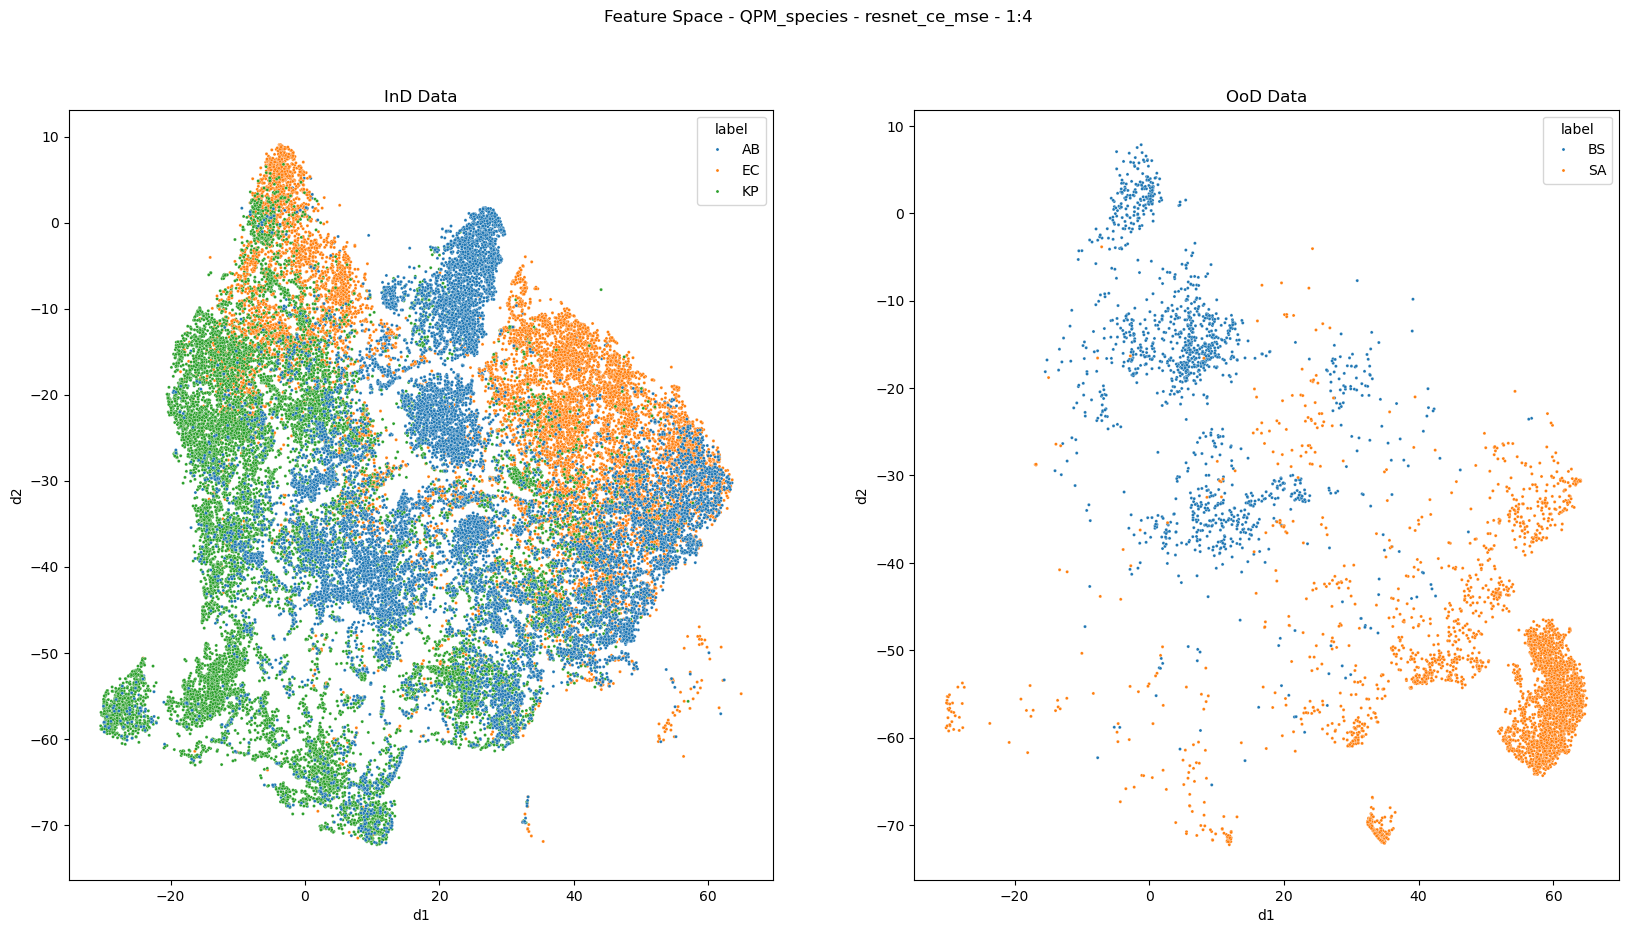

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

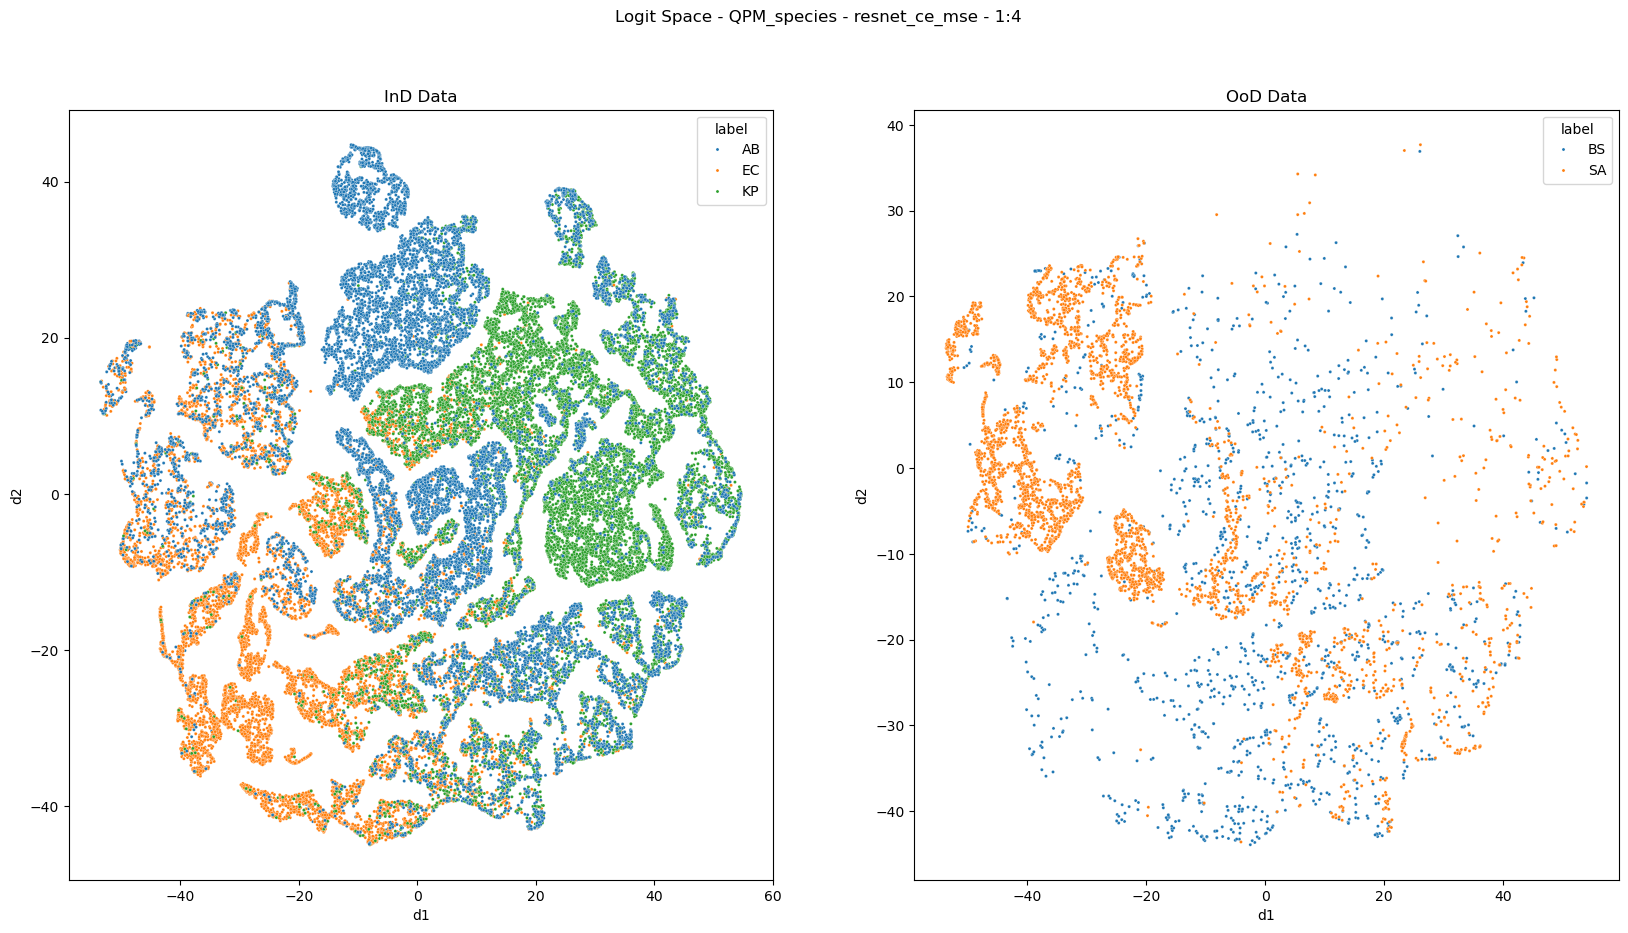

In [13]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:14<00:44, 14.72s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:29<00:29, 14.77s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:44<00:14, 14.89s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 15.07s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.98s/it]

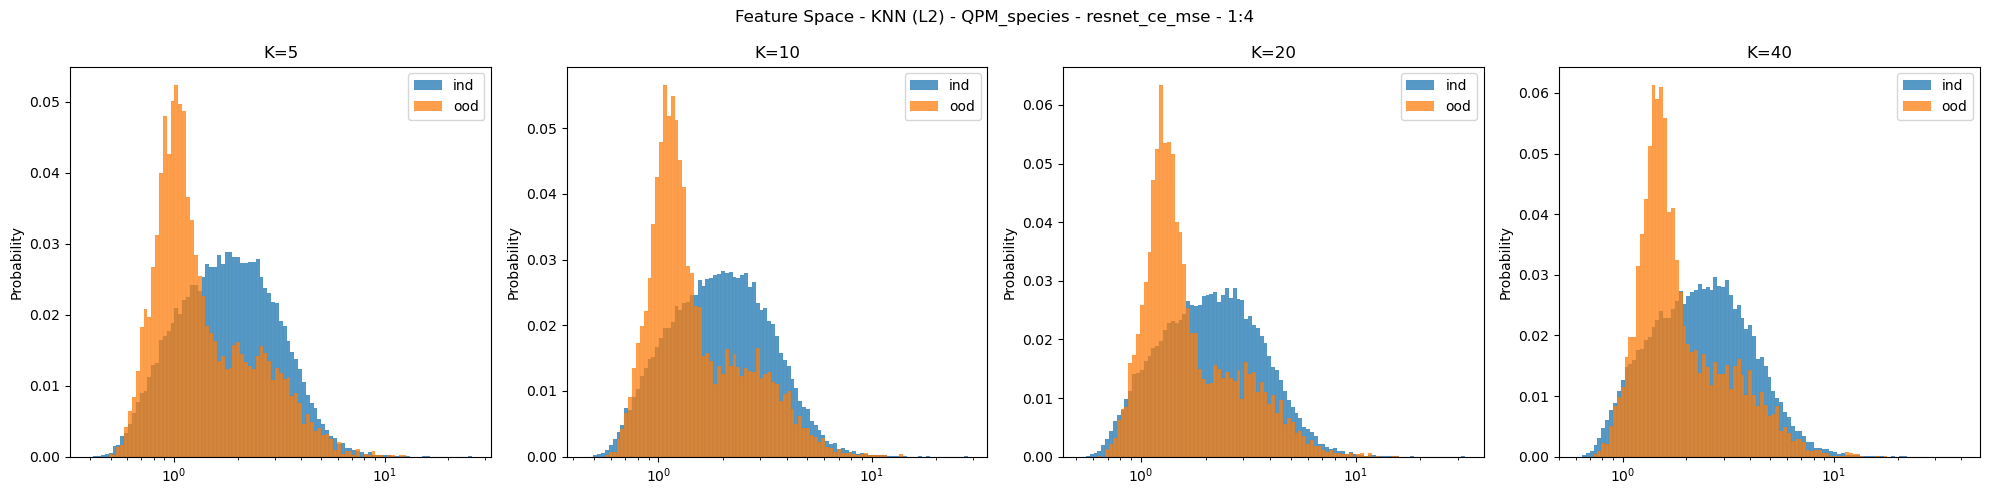

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:14<00:43, 14.49s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:29<00:29, 14.65s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:44<00:14, 14.71s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.89s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.80s/it]

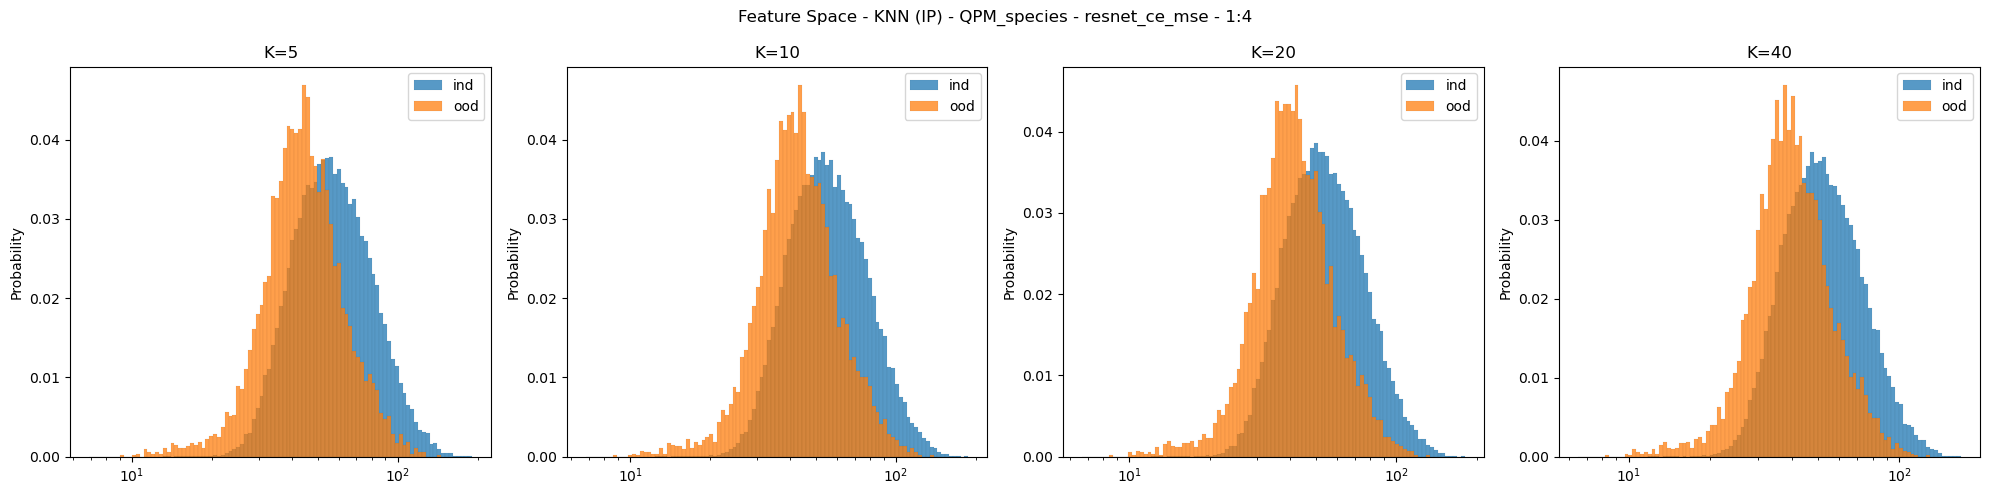

In [15]:
# plot knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:02<00:06,  2.06s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:04<00:04,  2.10s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:06<00:02,  2.19s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.35s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.27s/it]

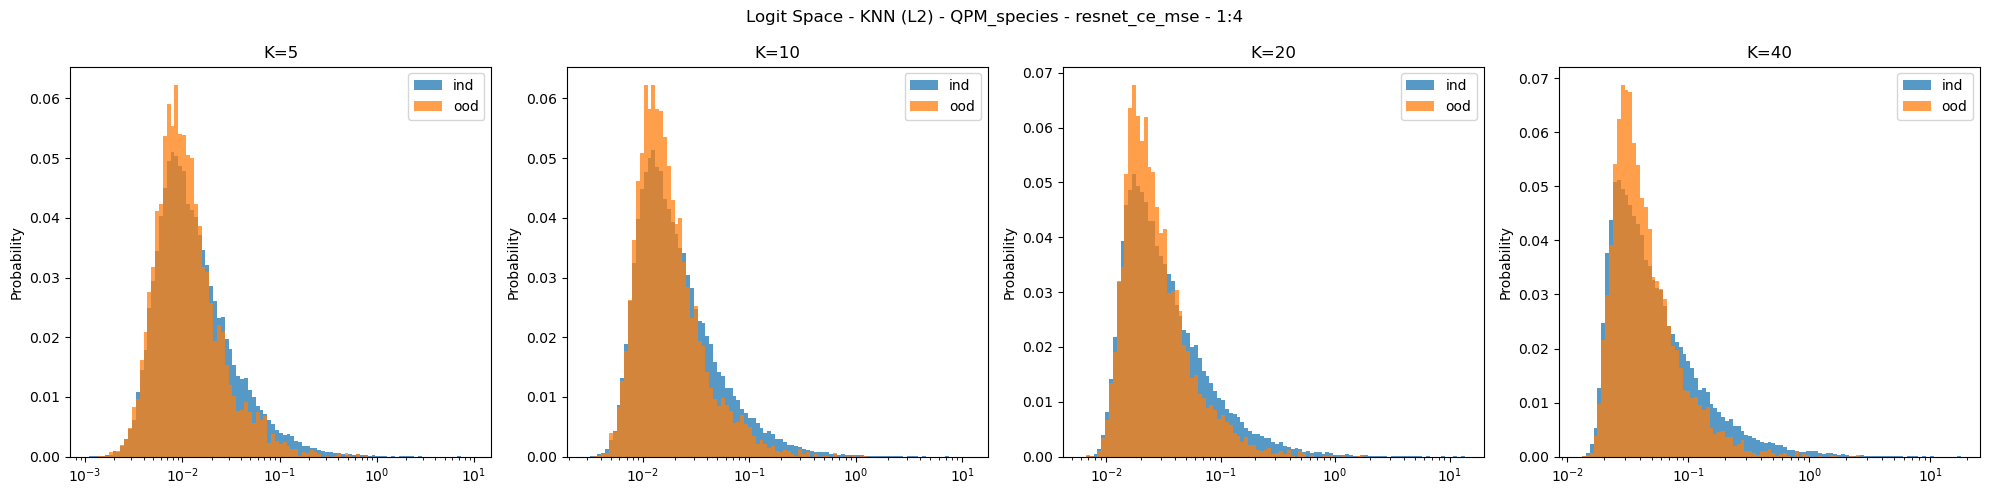

In [16]:
# plot knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:01<00:05,  1.80s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:03<00:03,  1.85s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:05<00:01,  1.95s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.05s/it]

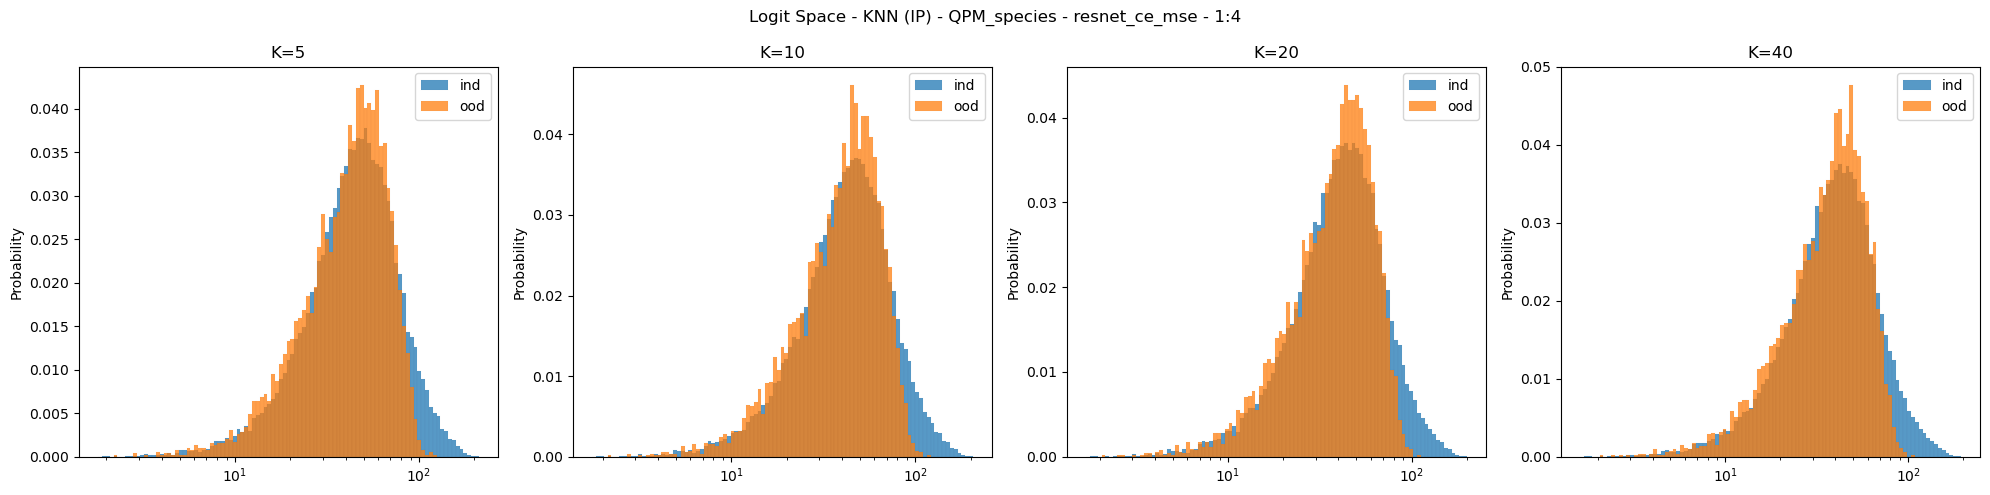

In [17]:
# plot knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

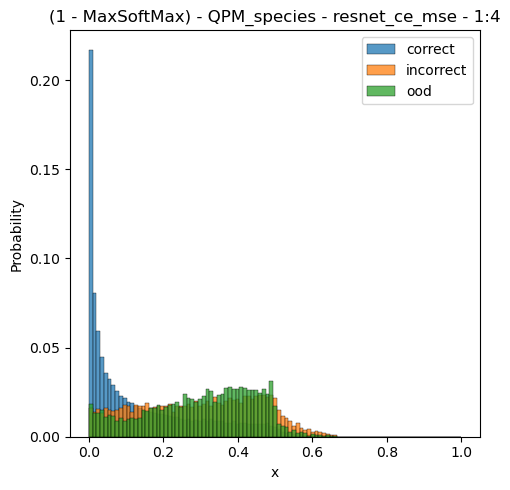

In [18]:
# plot (1 - maxsoftmax) distribution
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

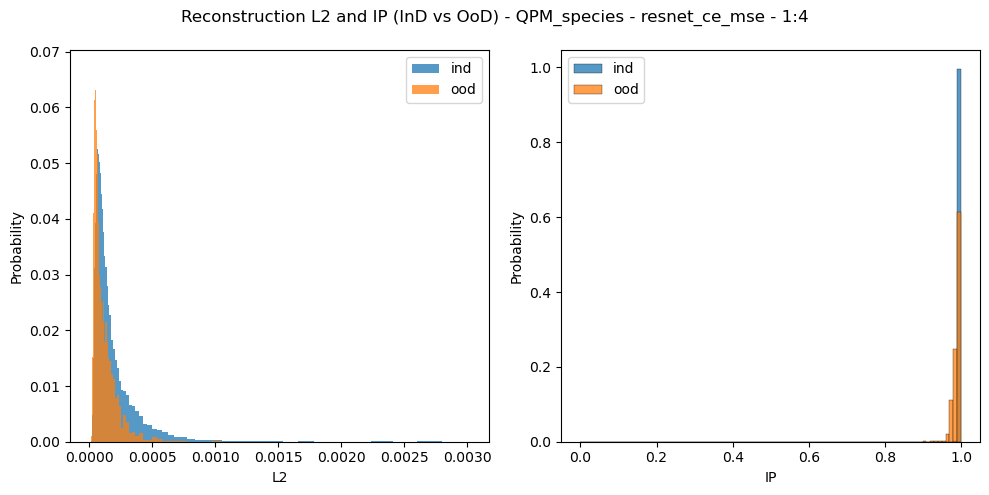

In [19]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()